In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline

import dipy.data as dpd
import dipy.core.sphere as dps 
import dipy.sims as sims
import dipy.core.gradients as grad
import dipy.core.geometry as geo
import nibabel as nib

import analysis as ana

In [2]:
# 65 direction DTI data
fdata, fbval, fbvec = dpd.get_data()
gtab = grad.gradient_table(fbval, fbvec)
gtab.bvals = gtab.bvals # Make the units work out
data_ni = nib.load(fdata)
data = data_ni.get_data()

/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/dipy/core/gradients.py:132: RuntimeWarning: invalid value encountered in less_equal
  bvecs_close_to_1 = abs(vector_norm(bvecs) - 1) <= atol


In [3]:
ni, gtab = dpd.read_stanford_hardi()

In [4]:
data = ni.get_data()

In [5]:
n_split = 75

In [6]:
data_train = np.concatenate([data[..., :5], data[..., 10:85]], -1)
data_test = np.concatenate([data[..., 5:10], data[..., 85:]], -1)

In [7]:
data_train.shape, data_test.shape

((81, 106, 76, 80), (81, 106, 76, 80))

In [8]:
gtab_train = grad.gradient_table_from_bvals_bvecs(np.concatenate([gtab.bvals[:5], gtab.bvals[10:85]]), 
                                                  np.concatenate([gtab.bvecs[:5], gtab.bvecs[10:85]]))

gtab_test = grad.gradient_table_from_bvals_bvecs(np.concatenate([gtab.bvals[5:10], gtab.bvals[85:]]), 
                                                 np.concatenate([gtab.bvecs[5:10], gtab.bvecs[85:]]))


In [9]:
sph1 = dpd.get_sphere()
#sph1 = dps.Sphere(xyz=[[1,0,0], [0,1,0], [0,0,1]])

In [10]:
dm_train = ana.design_matrix(gtab_train, sph1)

analysis.py:18: RuntimeWarning: divide by zero encountered in divide
  return vector / np.dot(vector, vector)


In [11]:
debug

ERROR: No traceback has been produced, nothing to debug.


In [12]:
pp_sig = ana.preprocess_signal(data_train, gtab_train, 40, 40, 40)

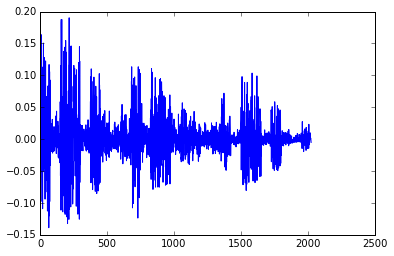

In [13]:
plt.plot(np.concatenate(pp_sig))

In [14]:
new_dm = np.concatenate(dm_train)
new_sig = np.concatenate(pp_sig)

In [15]:
from sklearn.linear_model import ElasticNet

In [16]:
EN = ElasticNet(alpha=0.0001, l1_ratio=0.8, positive=True)
beta = EN.fit(new_dm, new_sig).coef_
#beta, rnorm = opt.nnls(new_dm, new_sig)

ValueError: shapes (362,2100) and (2025,) not aligned: 2100 (dim 1) != 2025 (dim 0)

In [ ]:
new_dm.shape, new_sig.shape

In [ ]:
y_hat = np.dot(new_dm, beta)

In [ ]:
plt.plot(beta)

In [ ]:
plt.scatter(y_hat, new_sig)

In [ ]:
plt.scatter(y_hat[:n_split], new_sig[:n_split])
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')

In [ ]:
plt.scatter(y_hat[n_split:], new_sig[n_split:])

In [ ]:
#beta_non, rnorm = opt.nnls(new_dm[:n_split], new_sig[:n_split])
EN = ElasticNet(alpha=0.0001, l1_ratio=0.8, positive=True)

#beta_non, rnorm = opt.nnls(new_dm[:n_split], new_sig[:n_split])

beta_non = EN.fit(new_dm[:n_split], new_sig[:n_split]).coef_


In [ ]:
y_hat_non = np.dot(new_dm[:n_split], beta_non)

In [ ]:
plt.scatter(y_hat_non[:n_split], new_sig[:n_split])
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')

In [ ]:
fig, ax = plt.subplots(2)
ax[0].plot(beta_non)
ax[1].plot(beta)

In [ ]:
np.dot(beta_non, beta_non), np.dot(beta, beta)

In [ ]:
(np.sqrt(np.mean( (y_hat_non[:n_split]- new_sig[:n_split]) ** 2))/
np.sqrt(np.mean( (new_sig[:n_split] - y_hat[:n_split])**2 ) ))

In [ ]:
dm_test = np.concatenate(ana.design_matrix(gtab_test, sph1))

In [ ]:
y_hat_test = np.dot(dm_test, beta)
y_hat_non_test = np.dot(dm_test, beta_non)

In [ ]:
sig_test = np.concatenate(ana.preprocess_signal(data_test, gtab_train, 40, 40, 40))

In [ ]:
plt.plot(y_hat_test[:n_split], sig_test[:n_split], 'o')
plt.plot(y_hat_non_test[:n_split], sig_test[:n_split], 'go')
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')

In [ ]:
(np.sqrt(np.mean( (y_hat_non_test[:n_split]- sig_test[:n_split]) ** 2))/
np.sqrt(np.mean((sig_test[:n_split] - y_hat_test[:n_split])**2 )))

In [ ]:
import dipy.viz.fvtk as fvtk

In [ ]:
def plot_peaks(beta, sphere, fname=None):
    idx = np.where(beta>0)
    peak_dirs = sphere.vertices[idx]
    peak_values = beta[idx]
    ren = fvtk.ren()
    beta_peaks = fvtk.peaks(peak_dirs, peak_values)
    fvtk.add(ren, beta_peaks)
    if fname is None:
        fvtk.show(ren)
    else:
        fvtk.record(ren, out_path=fname) 

In [ ]:
plot_peaks(beta, sph1, fname='./fig.png')

In [ ]:
!open fig.png